In [310]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
color_pal = sns.color_palette()

In [311]:
df = pd.read_csv('all_data_for_one_street.csv')
df = df.set_index('Violation Datetime')
df.index = pd.to_datetime(df.index)

In [312]:
df

,Issue Date,Violation Precinct,Violation Time,Street Name,Violation_Rate
Violation Datetime,,,,,
2016-06-29 16:23:00,06/29/2016,78,16:23,13TH STREET,20.000000
2016-06-29 20:40:00,06/29/2016,78,20:40,13TH STREET,16.666667
2016-06-30 08:52:00,06/30/2016,78,08:52,13TH STREET,50.000000
2016-06-30 08:53:00,06/30/2016,78,08:53,13TH STREET,50.000000
2016-06-30 08:55:00,06/30/2016,78,08:55,13TH STREET,50.000000
...,...,...,...,...,...
2023-09-28 03:09:00,09/28/2023,78,03:09,13TH STREET,9.803922
2023-09-28 03:11:00,09/28/2023,78,03:11,13TH STREET,9.803922
2023-09-28 03:13:00,09/28/2023,78,03:13,13TH STREET,9.803922


In [313]:
df_1 = df.copy()

In [314]:
df_1['hour'] = df_1.index.hour
df_1["minute"] = df_1.index.minute
df_1["minute_quarter"] = pd.cut(df_1["minute"], bins=[0, 15, 30, 45, 60], labels=[1, 2, 3, 4], include_lowest=True, right=False)
df_1["minute_quarter"] = df_1["minute_quarter"].astype(int)
df_1['dayofweek'] = df_1.index.dayofweek
df_1['quarter'] = df_1.index.quarter
df_1['month'] = df_1.index.month
df_1['year'] = df_1.index.year
df_1['dayofyear'] = df_1.index.dayofyear
df_1['dayofmonth'] = df_1.index.day
df_1['weekofyear'] = df_1.index.isocalendar().week

In [315]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14803 entries, 2016-06-29 16:23:00 to 2023-09-28 03:17:00
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Issue Date          14803 non-null  object 
 1   Violation Precinct  14803 non-null  int64  
 2   Violation Time      14803 non-null  object 
 3   Street Name         14803 non-null  object 
 4   Violation_Rate      14803 non-null  float64
 5   hour                14803 non-null  int32  
 6   minute              14803 non-null  int32  
 7   minute_quarter      14803 non-null  int32  
 8   dayofweek           14803 non-null  int32  
 9   quarter             14803 non-null  int32  
 10  month               14803 non-null  int32  
 11  year                14803 non-null  int32  
 12  dayofyear           14803 non-null  int32  
 13  dayofmonth          14803 non-null  int32  
 14  weekofyear          14803 non-null  UInt32 
dtypes: UInt32(1), floa

In [316]:
df_1

,Issue Date,Violation Precinct,Violation Time,Street Name,Violation_Rate,hour,minute,minute_quarter,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Violation Datetime,,,,,,,,,,,,,,,
2016-06-29 16:23:00,06/29/2016,78,16:23,13TH STREET,20.000000,16,23,2,2,2,6,2016,181,29,26
2016-06-29 20:40:00,06/29/2016,78,20:40,13TH STREET,16.666667,20,40,3,2,2,6,2016,181,29,26
2016-06-30 08:52:00,06/30/2016,78,08:52,13TH STREET,50.000000,8,52,4,3,2,6,2016,182,30,26
2016-06-30 08:53:00,06/30/2016,78,08:53,13TH STREET,50.000000,8,53,4,3,2,6,2016,182,30,26
2016-06-30 08:55:00,06/30/2016,78,08:55,13TH STREET,50.000000,8,55,4,3,2,6,2016,182,30,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-28 03:09:00,09/28/2023,78,03:09,13TH STREET,9.803922,3,9,1,3,3,9,2023,271,28,39
2023-09-28 03:11:00,09/28/2023,78,03:11,13TH STREET,9.803922,3,11,1,3,3,9,2023,271,28,39
2023-09-28 03:13:00,09/28/2023,78,03:13,13TH STREET,9.803922,3,13,1,3,3,9,2023,271,28,39


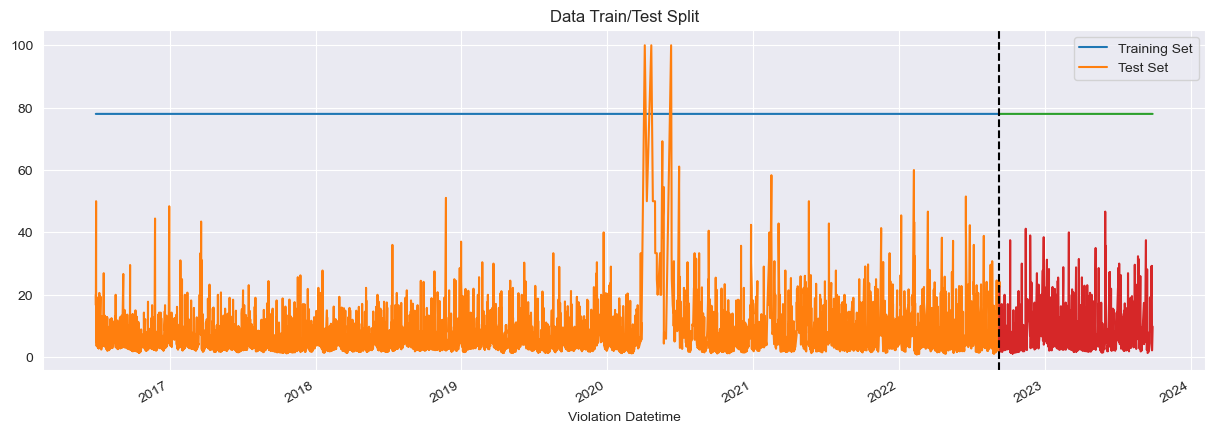

In [317]:
split_percentage = 0.85

split_index = int(len(df) * split_percentage)
train = df.iloc[:split_index]
test = df.iloc[split_index:]

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline(train.index[-1], color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [318]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*45*1, gap=24)
df_1 = df_1.sort_index()

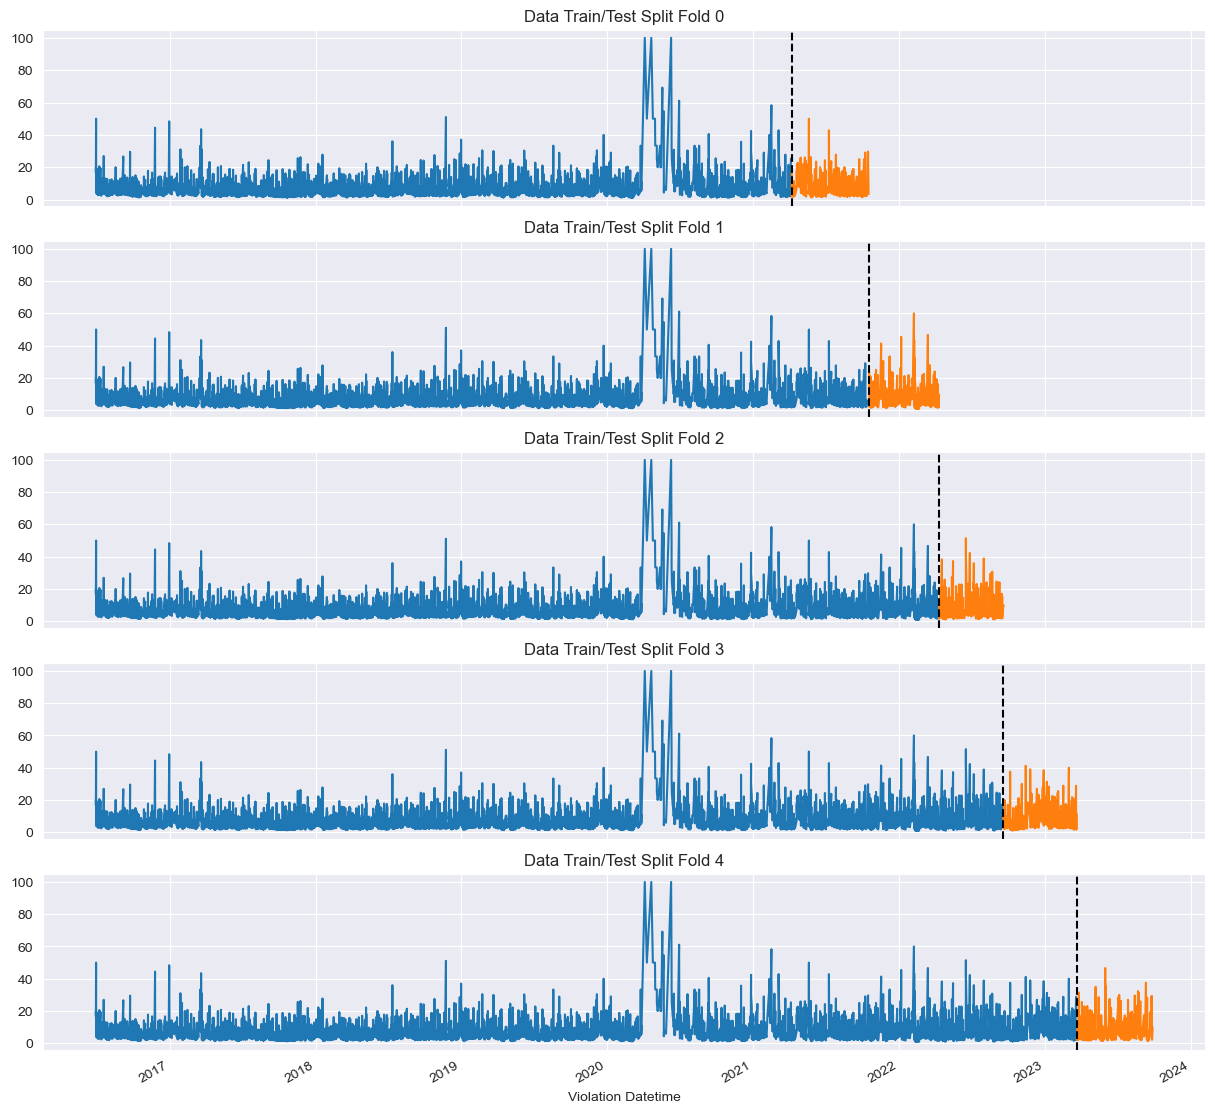

In [319]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df_1):
    train = df_1.iloc[train_idx]
    test = df_1.iloc[val_idx]
    train['Violation_Rate'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Violation_Rate'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [320]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df["minute"] = df.index.minute
    df["minute_quarter"] = pd.cut(df["minute"], bins=[0, 15, 30, 45, 60], labels=[1, 2, 3, 4], include_lowest=True)
    df["minute_quarter"] = df["minute_quarter"].astype(int)
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df_1 = create_features(df_1)
df_1

,Issue Date,Violation Precinct,Violation Time,Street Name,Violation_Rate,hour,minute,minute_quarter,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Violation Datetime,,,,,,,,,,,,,,,
2016-06-29 16:23:00,06/29/2016,78,16:23,13TH STREET,20.000000,16,23,2,2,2,6,2016,181,29,26
2016-06-29 20:40:00,06/29/2016,78,20:40,13TH STREET,16.666667,20,40,3,2,2,6,2016,181,29,26
2016-06-30 08:52:00,06/30/2016,78,08:52,13TH STREET,50.000000,8,52,4,3,2,6,2016,182,30,26
2016-06-30 08:53:00,06/30/2016,78,08:53,13TH STREET,50.000000,8,53,4,3,2,6,2016,182,30,26
2016-06-30 08:55:00,06/30/2016,78,08:55,13TH STREET,50.000000,8,55,4,3,2,6,2016,182,30,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-28 03:09:00,09/28/2023,78,03:09,13TH STREET,9.803922,3,9,1,3,3,9,2023,271,28,39
2023-09-28 03:11:00,09/28/2023,78,03:11,13TH STREET,9.803922,3,11,1,3,3,9,2023,271,28,39
2023-09-28 03:13:00,09/28/2023,78,03:13,13TH STREET,9.803922,3,13,1,3,3,9,2023,271,28,39


C:\Users\YSK\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\YSK\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\YSK\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


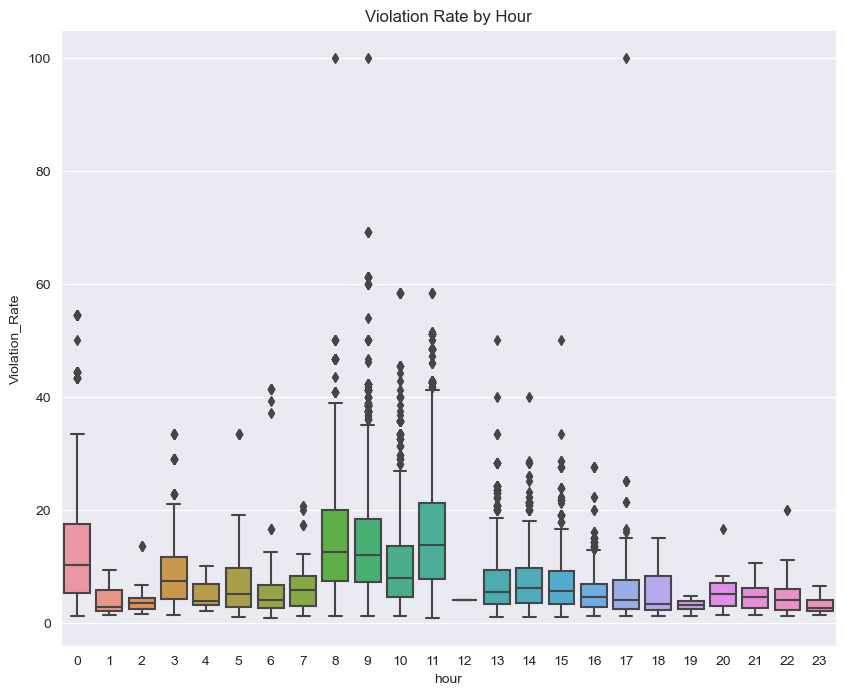

In [321]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_1, x='hour', y='Violation_Rate', ax=ax)
ax.set_title('Violation Rate by Hour')
plt.show()

C:\Users\YSK\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\YSK\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\YSK\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


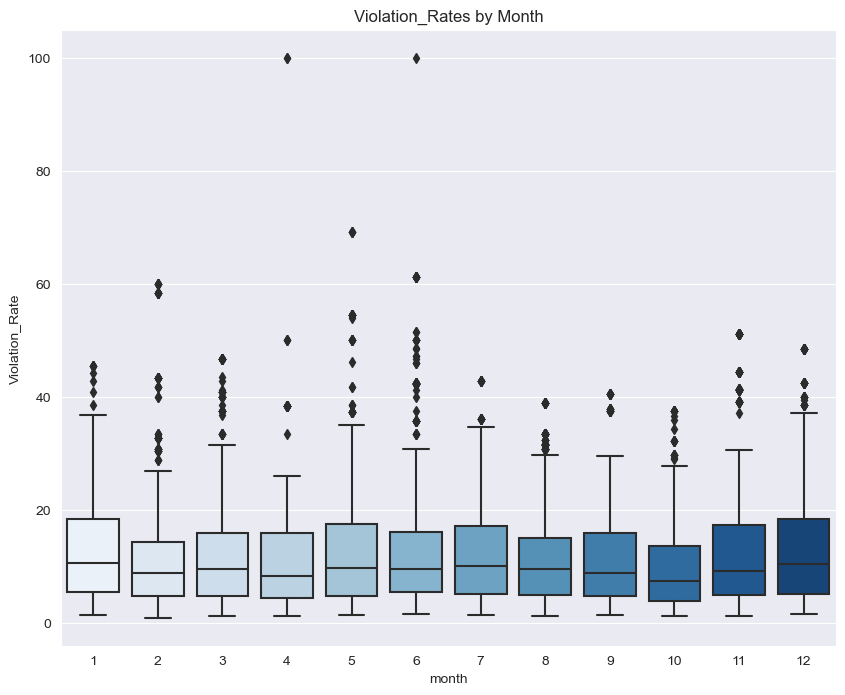

In [322]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_1, x='month', y='Violation_Rate', palette='Blues')
ax.set_title('Violation_Rates by Month')
plt.show()

In [323]:
def create_lag_features(data, n_lags, lag_column='Violation_Rate'):
    for i in range(1, n_lags+1):
        data[f'lag{i}'] = data[lag_column].shift(i*24)
    return data

n_lags = 5
df_1 = create_lag_features(df_1, n_lags, lag_column='Violation_Rate')

In [324]:
df_1

,Issue Date,Violation Precinct,Violation Time,Street Name,Violation_Rate,hour,minute,minute_quarter,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,lag4,lag5
Violation Datetime,,,,,,,,,,,,,,,,,,,,
2016-06-29 16:23:00,06/29/2016,78,16:23,13TH STREET,20.000000,16,23,2,2,2,6,2016,181,29,26,NaN,NaN,NaN,NaN,NaN
2016-06-29 20:40:00,06/29/2016,78,20:40,13TH STREET,16.666667,20,40,3,2,2,6,2016,181,29,26,NaN,NaN,NaN,NaN,NaN
2016-06-30 08:52:00,06/30/2016,78,08:52,13TH STREET,50.000000,8,52,4,3,2,6,2016,182,30,26,NaN,NaN,NaN,NaN,NaN
2016-06-30 08:53:00,06/30/2016,78,08:53,13TH STREET,50.000000,8,53,4,3,2,6,2016,182,30,26,NaN,NaN,NaN,NaN,NaN
2016-06-30 08:55:00,06/30/2016,78,08:55,13TH STREET,50.000000,8,55,4,3,2,6,2016,182,30,26,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-28 03:09:00,09/28/2023,78,03:09,13TH STREET,9.803922,3,9,1,3,3,9,2023,271,28,39,29.166667,1.315789,28.169014,21.276596,11.111111
2023-09-28 03:11:00,09/28/2023,78,03:11,13TH STREET,9.803922,3,11,1,3,3,9,2023,271,28,39,20.000000,1.851852,28.169014,21.276596,5.263158
2023-09-28 03:13:00,09/28/2023,78,03:13,13TH STREET,9.803922,3,13,1,3,3,9,2023,271,28,39,20.000000,4.444444,28.169014,21.276596,5.000000


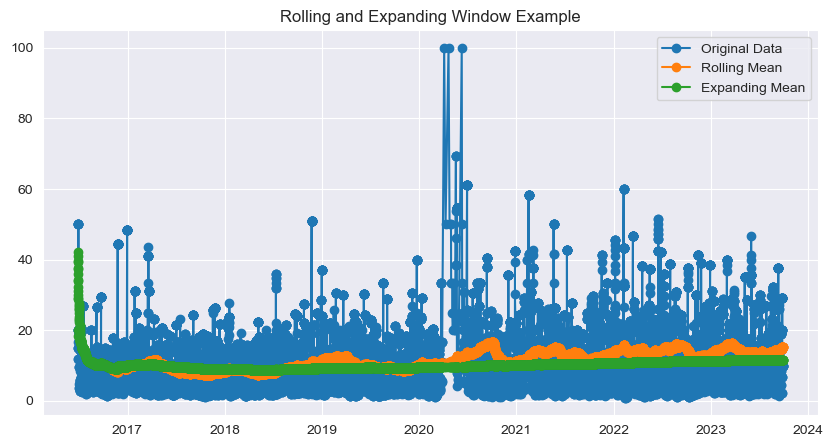

In [325]:
window_size = 24*7*4
df_1['Rolling_Mean'] = df_1['Violation_Rate'].rolling(window=window_size).mean()
df_1['Rolling_Std'] = df_1['Violation_Rate'].rolling(window=window_size).std()

df_1['Expanding_Mean'] = df_1['Violation_Rate'].expanding().mean()
df_1['Expanding_Std'] = df_1['Violation_Rate'].expanding().std()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df_1.index, df_1['Violation_Rate'], label='Original Data', marker='o')
ax.plot(df_1.index, df_1['Rolling_Mean'], label='Rolling Mean', marker='o')
ax.plot(df_1.index, df_1['Expanding_Mean'], label='Expanding Mean', marker='o')
ax.legend(loc='best')
ax.set_title('Rolling and Expanding Window Example')
plt.show()

In [326]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*45*1, gap=24)
df_1 = df_1.sort_index()

fold = 0
preds = []
scores = []
scores_r2 = []
for train_idx, val_idx in tss.split(df_1):
    train = df_1.iloc[train_idx]
    test = df_1.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'minute_quarter', 'dayofweek', 'quarter', 'month','year',
                'lag1', 'lag2', 'lag3', 'lag4', 'lag5']
    TARGET = 'Violation_Rate'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    score_r2 = r2_score(y_test, y_pred)
    scores_r2.append(score_r2)
    scores.append(score)

[0]	validation_0-rmse:13.07614	validation_1-rmse:14.64799
[100]	validation_0-rmse:8.77947	validation_1-rmse:9.33537


C:\Users\YSK\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:7.75386	validation_1-rmse:8.05859
[271]	validation_0-rmse:7.48990	validation_1-rmse:8.04238
[0]	validation_0-rmse:13.23701	validation_1-rmse:17.11425
[100]	validation_0-rmse:8.84310	validation_1-rmse:11.76180


C:\Users\YSK\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:7.85808	validation_1-rmse:10.50225
[300]	validation_0-rmse:7.57143	validation_1-rmse:10.22296
[400]	validation_0-rmse:7.40612	validation_1-rmse:10.17310
[443]	validation_0-rmse:7.33334	validation_1-rmse:10.16921
[0]	validation_0-rmse:13.66607	validation_1-rmse:17.95409
[100]	validation_0-rmse:9.11207	validation_1-rmse:12.16260


C:\Users\YSK\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:8.13062	validation_1-rmse:10.70766
[300]	validation_0-rmse:7.86846	validation_1-rmse:10.32991
[400]	validation_0-rmse:7.71903	validation_1-rmse:10.21040
[500]	validation_0-rmse:7.62622	validation_1-rmse:10.11095
[600]	validation_0-rmse:7.54508	validation_1-rmse:10.05296
[700]	validation_0-rmse:7.43787	validation_1-rmse:10.01537
[744]	validation_0-rmse:7.39356	validation_1-rmse:10.01844
[0]	validation_0-rmse:14.08569	validation_1-rmse:16.80218
[100]	validation_0-rmse:9.32962	validation_1-rmse:11.02828


C:\Users\YSK\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:8.31123	validation_1-rmse:9.82142
[300]	validation_0-rmse:8.02529	validation_1-rmse:9.53455
[400]	validation_0-rmse:7.88735	validation_1-rmse:9.39720
[500]	validation_0-rmse:7.78243	validation_1-rmse:9.32511
[600]	validation_0-rmse:7.69481	validation_1-rmse:9.28845
[654]	validation_0-rmse:7.64981	validation_1-rmse:9.28805
[0]	validation_0-rmse:14.29589	validation_1-rmse:16.65918
[100]	validation_0-rmse:9.45569	validation_1-rmse:10.29561


C:\Users\YSK\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:8.42038	validation_1-rmse:8.94255
[300]	validation_0-rmse:8.12285	validation_1-rmse:8.64267
[400]	validation_0-rmse:7.97185	validation_1-rmse:8.52083
[500]	validation_0-rmse:7.85847	validation_1-rmse:8.46666
[600]	validation_0-rmse:7.76496	validation_1-rmse:8.41046
[700]	validation_0-rmse:7.67775	validation_1-rmse:8.38576
[800]	validation_0-rmse:7.59988	validation_1-rmse:8.37093
[900]	validation_0-rmse:7.53788	validation_1-rmse:8.36173
[961]	validation_0-rmse:7.50109	validation_1-rmse:8.37239


In [327]:
y_pred

array([13.766848, 13.378468,  9.767642, ..., 10.707738, 10.368962,
       10.364137], dtype=float32)

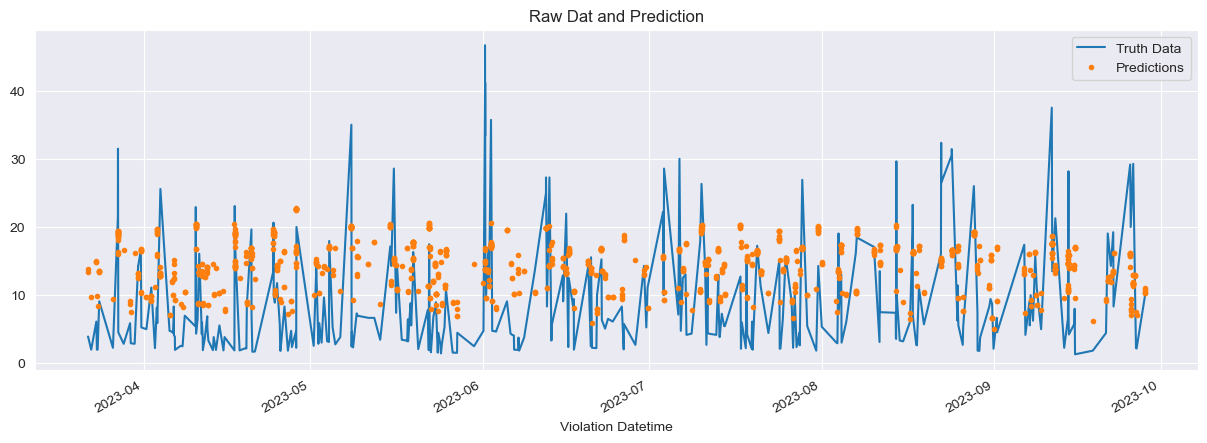

In [328]:
test['prediction'] = y_pred
y_test_ = pd.DataFrame(y_test)
y_test_ = y_test_.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = y_test_[['Violation_Rate']].plot(figsize=(15, 5))
y_test_['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [329]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')
print(f'R2 Score across folds {scores_r2}')
print(f'R2 Score across folds {np.mean(scores_r2):0.4f}')

Score across folds 9.1711
Fold scores:[8.02951335030004, 10.168593089648816, 10.01352439932076, 9.283174780138157, 8.360470167788048]
R2 Score across folds [0.06528758668728374, 0.05697034285547975, 0.15240214862679857, 0.18047902800349902, 0.2136133081597008]
R2 Score across folds 0.1338


In [330]:
def sub_plots_2(df_1, df_2, title ,m):
    fig, axes = plt.subplots(1, 2, figsize=(25,4), sharey=True, facecolor="#627D78")
    fig.suptitle(title)

    pl_1 = sns.lineplot(ax=axes[0], data=df_1, color=color_pal[m])
    axes[0].set(ylabel ="Prediction")

    pl_2 = sns.lineplot(ax=axes[1], data=df_2, color="#627D78")
    axes[1].set(ylabel ="Original")

C:\Users\YSK\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\YSK\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\YSK\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\YSK\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_c

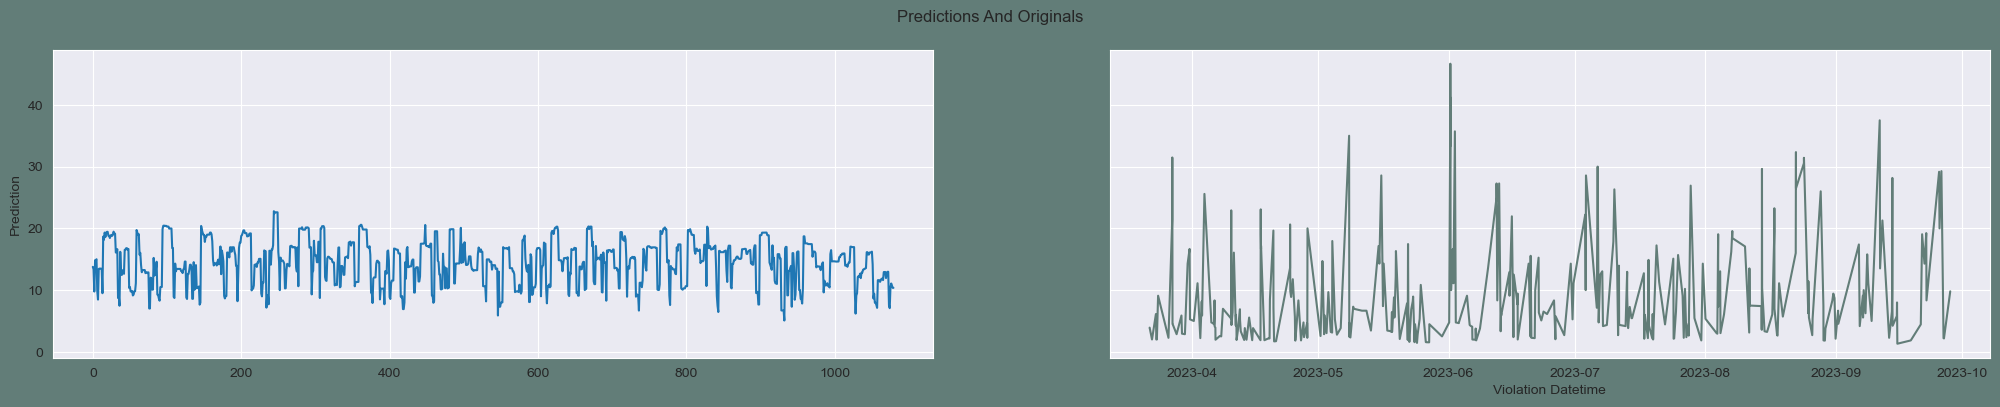

In [331]:
sub_plots_2(y_pred, y_test ,"Predictions And Originals", 0)

In [332]:
max_rate = df_1['Violation_Rate'].max()
df_1[df_1['Violation_Rate'] == max_rate]

,Issue Date,Violation Precinct,Violation Time,Street Name,Violation_Rate,hour,minute,minute_quarter,dayofweek,quarter,...,weekofyear,lag1,lag2,lag3,lag4,lag5,Rolling_Mean,Rolling_Std,Expanding_Mean,Expanding_Std
Violation Datetime,,,,,,,,,,,,,,,,,,,,,
2020-04-04 09:18:00,04/04/2020,78,09:18,13TH STREET,100.0,9,18,2,5,2,...,14,5.405405,10.526316,1.282051,8.791209,2.857143,10.777897,8.475720,9.493294,7.572204
2020-04-20 17:00:00,04/20/2020,78,17:00,13TH STREET,100.0,17,0,1,0,2,...,17,2.777778,5.263158,2.500000,3.614458,6.756757,10.986593,9.265359,9.510356,7.655300
2020-06-09 08:08:00,06/09/2020,78,08:08,13TH STREET,100.0,8,8,1,1,2,...,24,69.230769,33.333333,10.000000,13.333333,10.526316,12.739689,12.704525,9.672717,8.117661


In [333]:
df_1

,Issue Date,Violation Precinct,Violation Time,Street Name,Violation_Rate,hour,minute,minute_quarter,dayofweek,quarter,...,weekofyear,lag1,lag2,lag3,lag4,lag5,Rolling_Mean,Rolling_Std,Expanding_Mean,Expanding_Std
Violation Datetime,,,,,,,,,,,,,,,,,,,,,
2016-06-29 16:23:00,06/29/2016,78,16:23,13TH STREET,20.000000,16,23,2,2,2,...,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.000000,NaN
2016-06-29 20:40:00,06/29/2016,78,20:40,13TH STREET,16.666667,20,40,3,2,2,...,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.333333,2.357023
2016-06-30 08:52:00,06/30/2016,78,08:52,13TH STREET,50.000000,8,52,4,3,2,...,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.888889,18.358568
2016-06-30 08:53:00,06/30/2016,78,08:53,13TH STREET,50.000000,8,53,4,3,2,...,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.166667,18.333333
2016-06-30 08:55:00,06/30/2016,78,08:55,13TH STREET,50.000000,8,55,4,3,2,...,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.333333,17.384540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-28 03:09:00,09/28/2023,78,03:09,13TH STREET,9.803922,3,9,1,3,3,...,39,29.166667,1.315789,28.169014,21.276596,11.111111,15.385726,9.766418,11.676628,9.380614
2023-09-28 03:11:00,09/28/2023,78,03:11,13TH STREET,9.803922,3,11,1,3,3,...,39,20.000000,1.851852,28.169014,21.276596,5.263158,15.392379,9.761082,11.676501,9.380310
2023-09-28 03:13:00,09/28/2023,78,03:13,13TH STREET,9.803922,3,13,1,3,3,...,39,20.000000,4.444444,28.169014,21.276596,5.000000,15.399031,9.755738,11.676375,9.380006


In [334]:
from datetime import datetime

def categorize_minute(minute):
    if 0 <= minute <= 15:
        return 1
    elif 15 < minute <= 30:
        return 2
    elif 30 < minute <= 45:
        return 3
    else:
        return 4

def predict_violation_rate(input_date):
    input_datetime = datetime.strptime(input_date, "%Y-%m-%d %H:%M:%S")

    minute_category = categorize_minute(input_datetime.minute)

    input_features = [
        input_datetime.timetuple().tm_yday,  # dayofyear
        input_datetime.hour,
        minute_category,  # minute category
        input_datetime.weekday(),  # dayofweek
        (input_datetime.month - 1) // 3 + 1,  # quarter
        input_datetime.month,
        input_datetime.year,
        50, 50, 50, 50, 50,
    ]

    predicted_violation_rate = reg.predict([input_features])

    return predicted_violation_rate[0]

input_date = "2023-09-25 11:00:00"
predicted_rate = predict_violation_rate(input_date)
print(f"Modelin tahmini Violation Rate değeri: {predicted_rate}")

Modelin tahmini Violation Rate değeri: 20.53535270690918


In [335]:
combined_df = pd.concat([pd.DataFrame(y_pred), y_test.reset_index(drop=True)], axis=1)
combined_df.columns = ["Pred", "Original"]

In [336]:
combined_df

,Pred,Original
0,13.766848,3.921569
1,13.378468,3.921569
2,9.767642,2.000000
3,14.839661,6.122449
4,14.821825,6.122449
...,...,...
1075,10.431131,9.803922
1076,11.072085,9.803922
1077,10.707738,9.803922
1078,10.368962,9.803922
